## DvXray Classification Training Notebook (AHCR)
Multi-label Image Classification using AHCR

This notebook trains a **multi-label classifier** for the DvXray baggage security dataset.
It uses the dataset created by the preprocessing pipeline:



### DATA LOADER

In [8]:
from PIL import Image
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from utils import cvtColor, preprocess_input


class data_loader(Dataset):

    def __init__(self, annotation_lines, input_shape):
        super(data_loader, self).__init__()

        self.annotation_lines = annotation_lines
        self.length = len(annotation_lines)

        self.input_shape = input_shape

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        index = index % self.length

        line = self.annotation_lines[index].split()

        image_ol = cvtColor(Image.open(line[0]).resize(self.input_shape, Image.BILINEAR))
        image_sd = cvtColor(Image.open(line[1]).resize(self.input_shape, Image.BILINEAR))

        image_ol = self.get_random_data(image_ol)
        image_sd = self.get_random_data(image_sd)

        image_ol = np.transpose(preprocess_input(image_ol), (2, 0, 1))
        image_sd = np.transpose(preprocess_input(image_sd), (2, 0, 1))

        gt = np.array(list(map(int, line[2].split(','))))

        return image_ol, image_sd, gt


    def get_random_data(self, image, hue=.1, sat=0.7, val=0.4):

        image_data = np.array(image, np.uint8)

        r = np.random.uniform(-1, 1, 3) * [hue, sat, val] + 1

        hue, sat, val = cv2.split(cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV))
        dtype = image_data.dtype

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        image_data = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_HSV2RGB)

        return image_data

def DvX_dataset_collate(batch):

    img_ols, img_sds, gt_s = [], [], []

    for img_ol, img_sd, gt in batch:
        img_ols.append(img_ol)
        img_sds.append(img_sd)
        gt_s.append(gt)

    img_ols = torch.from_numpy(np.array(img_ols)).type(torch.FloatTensor)
    img_sds = torch.from_numpy(np.array(img_sds)).type(torch.FloatTensor)
    gt_s = torch.from_numpy(np.array(gt_s)).type(torch.FloatTensor)

    return img_ols, img_sds, gt_s

### LOSS FUNCTION

In [2]:
from torch import nn
import torch

class BCELoss(torch.nn.Module):
    def __init__(self, reduction='sum'):
        super(BCELoss, self).__init__()

        self.reduction = reduction
        self.loss_fct = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, ol_output, sd_output, gt_s):

        ol_bce_loss = self.loss_fct(ol_output, gt_s)

        sd_bce_loss = self.loss_fct(sd_output, gt_s)

        if self.reduction == 'mean':
            loss = torch.mean(ol_bce_loss + sd_bce_loss)
        elif self.reduction == 'sum':
            loss = torch.sum(ol_bce_loss + sd_bce_loss)
        return loss

### AVERAGE PRECISION METER

In [3]:
import torch
import math

class AveragePrecisionMeter(object):

    def __init__(self):
        super(AveragePrecisionMeter, self).__init__()

        self.reset()

    def reset(self):

        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):

        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'

        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        if self.scores.storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.storage().size() * 1.5)
            self.scores.storage().resize_(int(new_size + output.numel()))
            self.targets.storage().resize_(int(new_size + output.numel()))

        offset = self.scores.size(0) if self.scores.dim() > 0 else 0

        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):

        if self.scores.numel() == 0:
            return 0

        ap = torch.zeros(self.scores.size(1))

        for k in range(self.scores.size(1)):

            scores = self.scores[:, k]
            targets = self.targets[:, k]

            ap[k] = AveragePrecisionMeter.average_precision(scores, targets)
        return ap

    @staticmethod
    def average_precision(output, target):

        sorted, indices = torch.sort(output, dim=0, descending=True)

        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if label == 0:
                total_count += 1
            if label == 1:
                pos_count += 1
                total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        precision_at_i /= (pos_count + 1e-10)
        return precision_at_i


### UTILITIES

In [4]:
import numpy as np
from PIL import Image
import torch
from scipy import ndimage

def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[2] == 3:
        return image
    else:
        image = image.convert('RGB')
        return image

def preprocess_input(image):
    image = np.array(image, dtype=np.float32)[:, :, ::-1]
    mean = [0.91584104, 0.9297611, 0.939562]
    std = [0.22090791, 0.1861283, 0.1651021]
    return (image / 255. - mean) / std

def adjust_learning_rate(optimizer, shrink_factor):

    print("\nDecaying learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def clip_gradient(optimizer, grad_clip):

    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def confidence_weighted_view_fusion(ol_output, sd_output):

    total = torch.cat([torch.abs(ol_output - 0.5), torch.abs(sd_output - 0.5)], dim=0)
    coff = torch.softmax(total, dim=0)
    prediction = coff[0] * ol_output + coff[1] * sd_output

    return prediction


## AHCR (ResNet50 AND Multiview)

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models

# class h_swish(nn.Module):
#     def __init__(self, inplace=True):
#         super(h_swish, self).__init__()
#         self.relu = nn.ReLU6(inplace=inplace)
#
#     def forward(self, x):
#         return x * self.relu(x + 3) / 6

class r_func(nn.Module):

    def __init__(self, int_c, out_c, reduction=32):

        super(r_func, self).__init__()

        self.pool_h = nn.AdaptiveAvgPool2d((1, None))

        def _make_basic(input_dim, output_dim, kernel_size, stride, padding):

            return nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size, stride,
                          padding),
                nn.BatchNorm2d(output_dim))
        # self.act = h_swish()
        self.act = nn.ReLU6(inplace=True)
        self.dcov = _make_basic(int_c, (out_c // reduction), kernel_size=1, stride=1, padding=0)
        self.conv_h = nn.Conv2d((out_c // reduction), out_c, kernel_size=1, stride=1, padding=0)

    def forward(self, h_x, l_x, sig):

        B, _, H, W = l_x.size()
        m_x = self.pool_h(h_x)
        m_x = F.interpolate(m_x, size=(1, W), mode='bilinear')
        m_x = self.act(self.dcov(m_x))
        m_out = l_x * (self.conv_h(m_x).sigmoid())
        sig = sig.reshape((B, 1, 1, 1))
        out = l_x + sig * m_out

        return out



class AHCR(nn.Module):

    def __init__(self, num_classes=15):

        super(AHCR, self).__init__()

        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        for item in resnet.children():
            if isinstance(item, nn.BatchNorm2d):
                item.affine = False

        self.features = nn.Sequential(resnet.conv1,
                                      resnet.bn1,
                                      resnet.relu,
                                      resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.cov4_ol = nn.Conv2d(2048, 2048, kernel_size=1, stride=1)
        self.cov4_sd = nn.Conv2d(2048, 2048, kernel_size=1, stride=1)

        self.cov3_ol = nn.Conv2d(1024, 1024, kernel_size=1, stride=1)
        self.cov3_sd = nn.Conv2d(1024, 1024, kernel_size=1, stride=1)

        self.cov2_ol = nn.Conv2d(512, 512, kernel_size=1, stride=1)
        self.cov2_sd = nn.Conv2d(512, 512, kernel_size=1, stride=1)

        self.ol_r_sd_1 = r_func(2048, 1024)
        self.sd_r_ol_1 = r_func(2048, 1024)

        self.ol_r_sd_2 = r_func(1024, 512)
        self.sd_r_ol_2 = r_func(1024, 512)

        self.po1 = nn.AvgPool2d(7, stride=1)
        self.po2 = nn.AvgPool2d(14, stride=1)
        self.po3 = nn.AvgPool2d(28, stride=1)

        self.fc1_ol = nn.Linear(2048, num_classes)
        self.fc1_sd = nn.Linear(2048, num_classes)

        self.fc2_ol = nn.Linear(1024, num_classes)
        self.fc2_sd = nn.Linear(1024, num_classes)

        self.fc3_ol = nn.Linear(512, num_classes)
        self.fc3_sd = nn.Linear(512, num_classes)

        self.cos_similarity = nn.CosineSimilarity(dim=1, eps=1e-8)

        self.init_weights()

    def init_weights(self):

        for name, param in self.named_parameters():

            if name in ('cov4_ol.weight', 'cov4_sd.weight', 'cov3_ol.weight', 'cov3_sd.weight', 'cov2_ol.weight',
                        'cov2_sd.weight', 'ol_r_sd_1.dcov.0.weight', 'ol_r_sd_1.conv_h.weight', 'sd_r_ol_1.dcov.0.weight', 'sd_r_ol_1.conv_h.weight',
                        'ol_r_sd_2.dcov.0.weight', 'ol_r_sd_2.conv_h.weight', 'sd_r_ol_2.dcov.0.weight', 'sd_r_ol_2.conv_h.weight'):
                nn.init.orthogonal_(param)
            if name in ('cov4_ol.bias', 'cov4_sd.bias', 'cov3_ol.bias', 'cov3_sd.bias', 'cov2_ol.bias',
                        'cov2_sd.bias', 'ol_r_sd_1.dcov.0.bias', 'ol_r_sd_1.conv_h.bias', 'sd_r_ol_1.dcov.0.bias', 'sd_r_ol_1.conv_h.bias',
                        'ol_r_sd_2.dcov.0.bias', 'ol_r_sd_2.conv_h.bias', 'sd_r_ol_2.dcov.0.bias', 'sd_r_ol_2.conv_h.bias'):
                nn.init.constant_(param, 0.0)

            if name in ('fc1_ol.weight', 'fc1_sd.weight', 'fc2_ol.weight', 'fc2_sd.weight', 'fc3_ol.weight', 'fc3_sd.weight'):
                nn.init.normal_(param, 0, 0.01)
            if name in ('fc1_ol.bias', 'fc1_sd.bias', 'fc2_ol.bias', 'fc2_sd.bias', 'fc3_ol.bias', 'fc3_sd.bias'):
                nn.init.zeros_(param)

    def forward(self, image_ol, image_sd):

        bf_ol = self.features(image_ol)
        f_l1_o1 = self.layer1(bf_ol)
        f_l2_ol = self.layer2(f_l1_o1)
        f_l3_ol = self.layer3(f_l2_ol)
        f_l4_ol = self.layer4(f_l3_ol)

        bf_sd = self.features(image_sd)
        f_l1_sd = self.layer1(bf_sd)
        f_l2_sd = self.layer2(f_l1_sd)
        f_l3_sd = self.layer3(f_l2_sd)
        f_l4_sd = self.layer4(f_l3_sd)

        out1_ol = self.fc1_ol(self.po1(F.relu(self.cov4_ol(f_l4_ol))).view(f_l4_ol.size(0), -1))
        out1_sd = self.fc1_sd(self.po1(F.relu(self.cov4_sd(f_l4_sd))).view(f_l4_sd.size(0), -1))

        con_coe1 = F.relu(self.cos_similarity(out1_ol, out1_sd))

        out2_m_ol = self.cov3_ol(self.sd_r_ol_1(f_l4_sd, f_l3_ol, con_coe1))
        out2_m_sd = self.cov3_sd(self.ol_r_sd_1(f_l4_ol, f_l3_sd, con_coe1))

        out2_ol = self.fc2_ol(self.po2(F.relu(out2_m_ol)).view(out2_m_ol.size(0), -1))
        out2_sd = self.fc2_sd(self.po2(F.relu(out2_m_sd)).view(out2_m_sd.size(0), -1))

        con_coe2 = F.relu(self.cos_similarity(out2_ol, out2_sd))

        out3_m_ol = self.cov2_ol(self.sd_r_ol_2(out2_m_sd, f_l2_ol, con_coe2))
        out3_m_sd = self.cov2_sd(self.ol_r_sd_2(out2_m_ol, f_l2_sd, con_coe2))

        out3_ol = self.fc3_ol(self.po3(F.relu(out3_m_ol)).view(out3_m_ol.size(0), -1))
        out3_sd = self.fc3_sd(self.po3(F.relu(out3_m_sd)).view(out3_m_sd.size(0), -1))

        ol_output = (out1_ol + out2_ol + out3_ol) / 3.

        sd_output = (out1_sd + out2_sd + out3_sd) / 3.

        return ol_output, sd_output

if __name__ == '__main__':

    from thop import profile
    from thop import clever_format
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AHCR(num_classes=15).to(device)

    flops, params = profile(model, (torch.randn(1, 3, 224, 224).to(device), torch.randn(1, 3, 224, 224).to(device)))
    flops, params = clever_format([flops, params], '%.3f')
    print(flops)
    print(params)




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
9.498G
34.882M


### Trainin part
 - EPOCHS : 20
 - Learning rate = 0.01
 - Batch_size = 64
 - Optimizer = SGD

In [44]:
import torch
from model_ResNet import *


from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training parameters
start_epoch = 0
epochs = 25
input_shape = [224, 224]
learning_rate = 0.01
batch_size = 32
# batch_size = 64
grad_clip = 5.
print_freq = 100
train_annotation_path = 'DvXray_train.txt'

checkpoint = None

mAP_history = []



def save_checkpoint(epoch, model, optimizer):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),          
        'optimizer': optimizer.state_dict(),       
    }

    filename = f'ep{epoch+1:03d}_ResNet_checkpoint.pth.tar'
    torch.save(state, f'./checkpoint/{filename}')
    
def main():

    '''
    Training and Validation
    '''

    global checkpoint, start_epoch

    # ------------------------------------------------------
    # 1. Initialize model + optimizer (or load checkpoint)
    # ------------------------------------------------------
    model = AHCR(num_classes=15)

    optimizer = torch.optim.SGD(
        params=filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate
    )

    if checkpoint is not None:
        print(f"Loading checkpoint: {checkpoint}")

        ckpt = torch.load(checkpoint, map_location=device)

        start_epoch = ckpt['epoch'] + 1

        # Load weights correctly
        model.load_state_dict(ckpt['state_dict'])
        optimizer.load_state_dict(ckpt['optimizer'])

    else:
        start_epoch = 0

    model = model.to(device)

    # ------------------------------------------------------
    # 2. Criterion
    # ------------------------------------------------------
    criterion = BCELoss().to(device)

    # ------------------------------------------------------
    # 3. Build DataLoader
    # ------------------------------------------------------
    with open(train_annotation_path) as f:
        train_lines = f.readlines()

    train_loader = DataLoader(
        data_loader(train_lines, input_shape),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=DvX_dataset_collate
    )

    # ------------------------------------------------------
    # 4. Training Loop
    # ------------------------------------------------------
    for epoch in range(start_epoch, epochs):

        # learning rate schedule
        if epoch != 0 and epoch % 10 == 0:
            adjust_learning_rate(optimizer, 0.1)

        train(train_loader, model, criterion, optimizer, epoch)

        save_checkpoint(epoch, model, optimizer)

    
# def main():

#     '''
#     Training and Validation
#     '''

#     global checkpoint, start_epoch

#     if checkpoint is None:

#         model = AHCR(num_classes=15)

#         optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()),
#                                      lr=learning_rate)

#     else:

#         checkpoint = torch.load(checkpoint)
#         start_epoch = checkpoint['epoch'] + 1
#         model = checkpoint['model']
#         optimizer = checkpoint['optimizer']

#     model = model.to(device)

#     criterion = BCELoss().to(device)

#     with open(train_annotation_path) as f:
#         train_lines = f.readlines()

#     train_loader = DataLoader(data_loader(train_lines, input_shape), batch_size=batch_size, shuffle=True,
#                                drop_last=True, collate_fn=DvX_dataset_collate)

#     for epoch in range(start_epoch, epochs):

#         if epoch is not 0 and epoch % 10 == 0:
#             adjust_learning_rate(optimizer, 0.1)

#         train(train_loader, model, criterion, optimizer, epoch)

#         save_checkpoint(epoch, model, optimizer)


def train(train_loader, model, criterion, optimizer, epoch):

    model.train()

    Loss = []

    ap_meter = AveragePrecisionMeter()
    ap_meter.reset()

    for i, (img_ols, img_sds, gt_s) in enumerate(train_loader):

        img_ols = img_ols.to(device)
        img_sds = img_sds.to(device)
        gt_s = gt_s.to(device)

        ol_output, sd_output = model(img_ols, img_sds)

        loss = criterion(ol_output, sd_output, gt_s)

        optimizer.zero_grad()
        loss.backward()

        Loss.append(loss.item())

        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        optimizer.step()

        if i is not 0 and i % print_freq == 0:
            print('Epoch: [{}]/[{}/{}]\t'
                  'Loss: {:.3f}'.format((epoch + 1), i, len(train_loader),
                                        sum(Loss)/len(Loss),))

        prediction = confidence_weighted_view_fusion(torch.sigmoid(ol_output), torch.sigmoid(sd_output))

        ap_meter.add(prediction.data, gt_s)

    each_ap = ap_meter.value()
    map = 100 * each_ap.mean()

    print(each_ap)
    print('mAP: {:.3f}'.format(map))
    
    # store mAP for plotting
    mAP_history.append(map)


if __name__ == '__main__':
    main()

<>:175: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:175: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_73055/3799143323.py:175: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if i is not 0 and i % print_freq == 0:


### Draw a figure 

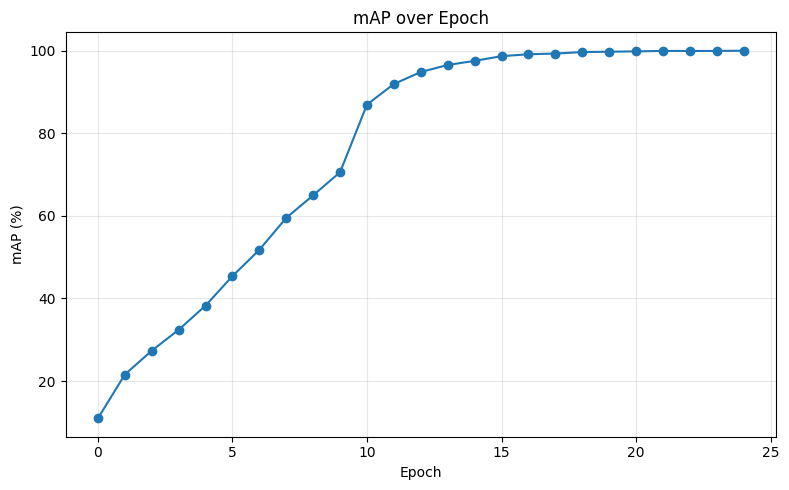

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(mAP_history, marker='o')
plt.title('mAP over Epoch')
plt.xlabel('Epoch')
plt.ylabel('mAP (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mAP_history.png', dpi=150)
plt.show()

## Test the model using a positive image

In [42]:
import torch
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape = (224, 224)

classes = ['Gun', 'Knife', 'Wrench', 'Pliers', 'Scissors', 'Lighter',
           'Battery', 'Bat', 'Razor_blade', 'Saw_blade', 'Fireworks',
           'Hammer', 'Screwdriver', 'Dart', 'Pressure_vessel']


def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, input_shape)
    img = img.astype(np.float32) / 255.

    img = np.stack([img, img, img], axis=0)  # (3,224,224)
    img = torch.tensor(img, dtype=torch.float32)
    return img.unsqueeze(0)  # (1,3,224,224)


def predict(checkpoint_path, image_id):
    print("Loading checkpoint:", checkpoint_path)

    # ----------------------------------------
    # Load AHCR model + correct state_dict
    # ----------------------------------------
    model = AHCR(num_classes=15).to(device)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(checkpoint.keys())

    model.load_state_dict(checkpoint["state_dict"])
    model.eval()

    # ----------------------------------------
    # Load OL and SD images
    # ----------------------------------------
    ol_path = f"./data/processed/classification/val/{image_id}_OL.png"
    sd_path = f"./data/processed/classification/val/{image_id}_SD.png"

    img_ol = load_img(ol_path).to(device)
    img_sd = load_img(sd_path).to(device)

    # ----------------------------------------
    # Forward pass
    # ----------------------------------------
    with torch.no_grad():
        ol_out, sd_out = model(img_ol, img_sd)

    ol_prob = torch.sigmoid(ol_out)
    sd_prob = torch.sigmoid(sd_out)

    fused = confidence_weighted_view_fusion(ol_prob, sd_prob)
    fused = fused.squeeze().cpu().numpy()

    # ----------------------------------------
    # Print predictions
    # ----------------------------------------
    print("\n===== Prediction =====")
    for cls, score in zip(classes, fused):
        print(f"{cls:15s}: {score:.4f}")

    print("\nDetected:")
    for cls, score in zip(classes, fused):
        if score > 0.5:
            print(f"✔ {cls}: {score:.3f}")


if __name__ == "__main__":
    predict("checkpoint/ep025_ResNet_checkpoint.pth.tar", "P00495")


Loading checkpoint: checkpoint/ep025_ResNet_checkpoint.pth.tar
dict_keys(['epoch', 'model', 'optimizer'])

===== Prediction =====
Gun            : 0.0000
Knife          : 0.0016
Wrench         : 0.0005
Pliers         : 0.0004
Scissors       : 0.0001
Lighter        : 0.0002
Battery        : 0.0010
Bat            : 0.0000
Razor_blade    : 0.0196
Saw_blade      : 0.0305
Fireworks      : 0.0880
Hammer         : 0.0000
Screwdriver    : 0.0012
Dart           : 0.1197
Pressure_vessel: 0.0004

Detected:
